### 기본 세팅

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150

In [2]:
# 파일 경로
charge_path = "/Users/kkkg0829/Desktop/project/data set/B0005_charge.csv"
discharge_path = "/Users/kkkg0829/Desktop/project/data set/B0005_discharge.csv"
imp_path = "/Users/kkkg0829/Desktop/project/data set/B0005_impedance.csv"

# 데이터 로드
charge = pd.read_csv(charge_path)
discharge = pd.read_csv(discharge_path)
imp = pd.read_csv(imp_path)

### Charge 데이터

In [3]:
charge

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,cycle_idx,type,ambient_temperature,start_time_raw
0,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...
1,3.479394,-4.030268,24.666480,-4.036,1.570,2.532,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...
2,4.000588,1.512731,24.675394,1.500,4.726,5.500,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...
3,4.012395,1.509063,24.693865,1.500,4.742,8.344,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...
4,4.019708,1.511318,24.705069,1.500,4.753,11.125,1,charge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.3000e+01 8...
...,...,...,...,...,...,...,...,...,...,...
541168,0.236356,-0.003484,23.372048,0.000,0.003,0.000,616,charge,24.0,[2008. 5. 28. 11. 9. ...
541169,0.003365,-0.001496,23.369434,0.000,0.003,2.547,616,charge,24.0,[2008. 5. 28. 11. 9. ...
541170,4.985137,0.000506,23.386535,0.000,5.002,5.500,616,charge,24.0,[2008. 5. 28. 11. 9. ...
541171,4.984720,0.000442,23.386983,-0.002,5.002,8.312,616,charge,24.0,[2008. 5. 28. 11. 9. ...


In [4]:
imp.duplicated().sum()

np.int64(0)

In [5]:
print("[Charge 데이터]")
charge.info()
print("\n결측치 개수:")
print(charge.isna().sum())

[Charge 데이터]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541173 entries, 0 to 541172
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Voltage_measured      541173 non-null  float64
 1   Current_measured      541173 non-null  float64
 2   Temperature_measured  541173 non-null  float64
 3   Current_charge        541173 non-null  float64
 4   Voltage_charge        541173 non-null  float64
 5   Time                  541173 non-null  float64
 6   cycle_idx             541173 non-null  int64  
 7   type                  541173 non-null  object 
 8   ambient_temperature   541173 non-null  float64
 9   start_time_raw        541173 non-null  object 
dtypes: float64(7), int64(1), object(2)
memory usage: 41.3+ MB

결측치 개수:
Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_charge          0
Voltage_charge          0
Time                    0
cycle_idx               

In [6]:
# charge 기초통계
## 전체 통계
print("\n [charge 데이터 전체 통계]")
charge[[
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_charge",
    "Voltage_charge",
    "Time"
]].describe()



 [charge 데이터 전체 통계]


,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
count,541173.000000,541173.000000,541173.000000,541173.000000,541173.000000,541173.000000
mean,4.158644,0.571543,25.770628,0.566810,4.184427,5062.836059
std,0.098078,0.620454,1.643729,0.616015,1.112792,3114.798871
min,0.003365,-4.479660,23.246728,-4.468000,0.003000,0.000000
25%,4.195473,0.058024,24.438659,0.057000,4.250000,2271.610000
50%,4.205310,0.227544,25.255235,0.225000,4.332000,4982.078000
75%,4.205978,1.506508,26.819807,1.498000,4.688000,7763.219000
max,8.393141,1.531301,31.187718,1.500000,5.002000,10807.328000


(1) 충전 과정은 일관된 프로토콜(CC → CV) 로 운영되고 있으며, 전압 범위(4.19~4.21V 근처)와 충전 시간 분포가 매우 안정적임

(2) 온도 범위가 일정하며 과도한 발열이 없으므로, 실험 환경은 외부 요인 없이 안정적 → 나중에 발생하는 변화는 배터리 자체 열화에 의한 것일 가능성 ↑

(3) Current와 Voltage 설정치에 비해 실제 측정값의 편차가 존재하지만, 패턴이 반복적

In [7]:
## cycle 1 통계
print("\n [cycle 1 통계]")
charge[charge['cycle_idx'] == 1][[
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_charge",
    "Voltage_charge",
    "Time"
]].describe()


 [cycle 1 통계]


,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
count,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000
mean,4.187420,0.643455,25.324079,0.638452,4.359487,2725.952433
std,0.045794,0.625804,1.011951,0.621598,0.881125,2233.400767
min,3.479394,-4.030268,24.167062,-4.036000,0.003000,0.000000
25%,4.190885,0.084497,24.404019,0.081000,4.261000,702.500000
50%,4.205710,0.387115,25.060947,0.382000,4.402000,2177.047000
75%,4.206481,1.496159,26.056859,1.485000,4.823000,4467.703000
max,4.209949,1.514393,27.445134,1.500000,4.931000,7597.875000


(1) 첫 충전 사이클은 정상적이며 안정적인 조건에서 진행되었고, 전압·전류·온도 패턴이 예상되는 리튬이온 셀의 CC-CV 충전 특징과 완전히 일치

(2) 급격한 노이즈나 급변 패턴이 없으므로, 이 데이터를 향후 사이클 열화 비교 기준(베이스라인) 으로 사용할 수 있음 (+하경님이 보내주신 근거 기반)

(3) 온도 상승폭이 크지 않고 전류값 진동이 제한적 → 배터리 내부 저항(IR) 및 열화가 거의 없는 초반 상태를 반영

In [8]:
# charge_cycle 단위로 요약

charge_cycle_stats = (
    charge
    .groupby("cycle_idx")
    .agg(
        chg_temp_mean=("Temperature_measured", "mean"),  # 평균 온도
        chg_temp_max=("Temperature_measured", "max"),    # 최대 온도
        chg_volt_mean=("Voltage_measured", "mean"),      # 평균 전압
        chg_volt_max=("Voltage_measured", "max"),        # 최대 전압
        chg_current_mean=("Current_measured", "mean"),   # 평균 전류
        chg_current_set=("Current_charge", "mean"),      # 설정 전류 평균
        chg_duration=("Time", "max"),                    # 충전 시간 (사이클당)
        chg_samples=("Time", "size")                     # 샘플 개수
    )
    .reset_index()
)

charge_cycle_stats.head()

,cycle_idx,chg_temp_mean,chg_temp_max,chg_volt_mean,chg_volt_max,chg_current_mean,chg_current_set,chg_duration,chg_samples
0,1,25.324079,27.445134,4.187420,4.209949,0.643455,0.638452,7597.875,789
1,3,26.635623,29.341949,4.058826,4.213016,0.949043,0.941762,10516.000,940
2,5,26.778176,29.553301,4.058139,4.212788,0.950529,0.943114,10484.547,937
3,7,26.703204,29.456340,4.058905,4.212924,0.952312,0.944735,10397.890,933
4,9,26.617004,29.481334,4.058330,4.212874,0.947728,0.940361,10495.203,937


In [9]:
print("\n[충전 사이클 요약 describe]")
charge_cycle_stats.describe()


[충전 사이클 요약 describe]


,cycle_idx,chg_temp_mean,chg_temp_max,chg_volt_mean,chg_volt_max,chg_current_mean,chg_current_set,chg_duration,chg_samples
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,291.170588,25.810156,29.492030,4.138058,4.239209,0.618220,0.613154,10350.963571,3183.370588
std,187.212850,0.566436,0.830880,0.105652,0.325947,0.179095,0.177740,1111.124227,1158.440641
min,1.000000,23.380012,23.386983,2.884604,4.208757,-0.000953,-0.000800,12.656000,5.000000
25%,125.000000,25.490143,29.301397,4.141042,4.209070,0.499874,0.495587,10172.976750,3565.250000
50%,286.000000,25.761677,29.560685,4.163416,4.209601,0.557794,0.553224,10559.641000,3738.500000
75%,454.000000,26.185366,29.856684,4.174754,4.209854,0.656589,0.651020,10790.355500,3834.750000
max,616.000000,27.394757,31.187718,4.210968,8.393141,0.969751,0.961923,10807.328000,3900.000000


(1) chg_volt_max는 거의 항상 4.21V 근처 → 충전 cut-off 전압이 일정

(2) chg_current_set는 0.9~1A 수준 → 충전 프로토콜이 사이클마다 거의 동일

(3) chg_temp_max도 크게 요동치지 않음 → 운전 조건이 매우 안정적

### Discharge

In [10]:
discharge

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity,cycle_idx,type,ambient_temperature,start_time_raw
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487,2,discharge,24.0,[2.0080e+03 4.0000e+00 2.0000e+00 1.5000e+01 2...
...,...,...,...,...,...,...,...,...,...,...,...
50280,3.579262,-0.001569,34.864823,0.0006,0.000,2781.312,1.325079,614,discharge,24.0,[2008. 5. 27. 20. 45. ...
50281,3.581964,-0.003067,34.814770,0.0006,0.000,2791.062,1.325079,614,discharge,24.0,[2008. 5. 27. 20. 45. ...
50282,3.584484,-0.003079,34.676258,0.0006,0.000,2800.828,1.325079,614,discharge,24.0,[2008. 5. 27. 20. 45. ...
50283,3.587336,0.001219,34.565580,0.0006,0.000,2810.640,1.325079,614,discharge,24.0,[2008. 5. 27. 20. 45. ...


In [11]:
print("[Discharge 데이터]")
discharge.info()
print("\n결측치 개수:")
print(discharge.isna().sum())

[Discharge 데이터]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50285 entries, 0 to 50284
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      50285 non-null  float64
 1   Current_measured      50285 non-null  float64
 2   Temperature_measured  50285 non-null  float64
 3   Current_load          50285 non-null  float64
 4   Voltage_load          50285 non-null  float64
 5   Time                  50285 non-null  float64
 6   Capacity              50285 non-null  float64
 7   cycle_idx             50285 non-null  int64  
 8   type                  50285 non-null  object 
 9   ambient_temperature   50285 non-null  float64
 10  start_time_raw        50285 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 4.2+ MB

결측치 개수:
Voltage_measured        0
Current_measured        0
Temperature_measured    0
Current_load            0
Voltage_load            0
Time       

In [12]:
# discharge 기초통계
## 전체 통계
print("\n [Discharge 데이터 전체 통계]")
discharge[[
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
    "Time",
    "Capacity"
]].describe()



 [Discharge 데이터 전체 통계]


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
count,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924,1.560345
std,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295,0.182380
min,2.455679,-2.029098,23.214802,-1.998400,-0.000000,0.000000,1.287453
25%,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000,1.386229
50%,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000,1.538237
75%,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000,1.746871
max,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000,1.856487


(1) 전류는 거의 -2A 일정한 Constant Current 방전(CC discharge) 방식

- Current_measured min 값이 -2.02A 근처

- 25%, 50%, 75% 값이 거의 동일

→ 즉, 변동 없는 일정 전류로 테스트함 → 데이터 신뢰도 높음

(2) 전압은 cycle 진행에 따라 감소하는 걸로 추정 → 정상적인 방전 특성

- 최고값 4.22V → 최소 2.45V

→ 이 2.45V 근처가 cut-off 방전 전압 역할 (용량 측정 기준 전압이 명확)

(3) 온도는 평균 32℃, 최대 41℃까지 상승

→ 방전 과정에서 발열이 존재

→ 열화 후반부 cycle일수록 온도 상승 속도가 증가할 가능성 (열화센서 feature로 활용 가능)

(4) Capacity의 분포는 열화 힌트 제공

초기 용량 1.85Ah → 후반에는 1.28Ah 수준까지 감소하는 capacity fade(열화)가 확인

(5) Time, Capacity : 비례 관계

Capacity (Ah) = Current (A) × Time (hours)

current는 -2A 정도로 거의 일정

-> capacity는 time에 거의 비례

=> discharge duration은 capacity의 간접지표로 활용 가능

In [13]:
## cycle 2 통계
print("\n [cycle 2 통계]")
discharge[discharge['cycle_idx'] == 2][[
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
    "Time",
    "Capacity"
]].describe()


 [cycle 2 통계]


,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,1.970000e+02
mean,3.529829,-1.818702,32.572328,-1.805570,2.404944,1812.087497,1.856487e+00
std,0.236558,0.595058,3.495804,0.591217,0.796974,1069.272600,4.452206e-16
min,2.612467,-2.018015,24.325993,-1.998400,0.000000,0.000000,1.856487e+00
25%,3.418746,-2.013447,30.422589,-1.998200,2.498000,891.812000,1.856487e+00
50%,3.529903,-2.012427,32.865786,-1.998200,2.610000,1796.328000,1.856487e+00
75%,3.685214,-2.011144,35.095568,-1.998200,2.765000,2724.203000,1.856487e+00
max,4.191492,0.000729,38.982181,-0.000400,4.206000,3690.234000,1.856487e+00


(1) 전류는 일정 → 실험 조건이 매우 안정적

- Current_measured 25%, 50%, 75% 값이 거의 동일 (-2.01A 근처)

- 이는 Constant Current Discharge(CCD) 실험이 성공적으로 수행되었다는 의미

→ 즉, 변화는 전류 때문이 아니라 배터리 상태 변화 때문이라고 해석 가능

(2) Voltage_measured min = 2.612V → 이 cycle의 cut-off 전압

(3) Temperature가 24℃ → 39℃까지 증가

(4) Capacity가 고정된 하나의 값

“이 cycle에서 배터리가 제공한 총 사용 가능한 에너지” = cycle health score

(5) Time ≈ 1,812초 평균 / 3,690초 max

이 사이클의 방전 지속 시간은 대략 30분 ~ 1시간 사이

In [14]:
# discharge_cycle 단위로 요약
cycle_stats = (
    discharge
    .groupby("cycle_idx")
    .agg(
        capacity_max=("Capacity", "max"),          # 사이클별 최대 용량
        temp_mean=("Temperature_measured", "mean"),
        temp_max=("Temperature_measured", "max"),
        volt_mean=("Voltage_measured", "mean"),
        volt_min=("Voltage_measured", "min"),
        current_mean=("Current_measured", "mean"),
        duration=("Time", "max"),
        n_samples=("Time", "size")
    )
    .reset_index()
)

cycle_stats

,cycle_idx,capacity_max,temp_mean,temp_max,volt_mean,volt_min,current_mean,duration,n_samples
0,2,1.856487,32.572328,38.982181,3.529829,2.612467,-1.818702,3690.234,197
1,4,1.846327,32.725235,39.033398,3.537320,2.587209,-1.817560,3672.344,196
2,6,1.835349,32.642862,38.818797,3.543737,2.651917,-1.816487,3651.641,195
3,8,1.835263,32.514876,38.762305,3.543666,2.592948,-1.825589,3631.563,194
4,10,1.834646,32.382349,38.665393,3.542343,2.547420,-1.826114,3629.172,194
...,...,...,...,...,...,...,...,...,...
163,600,1.293464,33.275688,40.983663,3.466462,2.668737,-1.674488,2793.390,297
164,604,1.288003,33.320678,40.982342,3.468509,2.696396,-1.667447,2793.390,297
165,608,1.287453,33.373150,41.063751,3.466806,2.679483,-1.667470,2792.485,297
166,612,1.309015,33.713519,41.047030,3.471071,2.678714,-1.688898,2802.016,298


In [15]:
print("\n[방전 사이클 요약 describe]")
cycle_stats.describe()


[방전 사이클 요약 describe]


,cycle_idx,capacity_max,temp_mean,temp_max,volt_mean,volt_min,current_mean,duration,n_samples
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,294.000000,1.572502,32.791319,39.845110,3.516787,2.648939,-1.807073,3129.523887,299.315476
std,184.947314,0.190413,0.713631,1.118020,0.032727,0.049297,0.084677,246.654499,56.074922
min,2.000000,1.287453,31.329996,37.801336,3.464021,2.455679,-1.938881,2792.485000,179.000000
25%,133.000000,1.390021,32.282375,38.804674,3.486639,2.636105,-1.883128,2901.343750,300.000000
50%,292.000000,1.557085,32.856923,40.080753,3.514629,2.660192,-1.816639,3086.078000,314.500000
75%,454.000000,1.769163,33.356184,40.865238,3.551061,2.682589,-1.727548,3323.230750,335.250000
max,614.000000,1.856487,34.310885,41.450232,3.564103,2.699983,-1.667447,3690.234000,371.000000


(1) cycle_idx: 2,4,6,…,614 (짝수) → charge와 짝을 이루는 방전 사이클

(2) 

    - cycle 2: 1.856 Ah

    - cycle 608: 1.287 Ah

    -> cycle이 진행될수록 capacity가 거의 단조 감소하는 “열화 커브”를 형성

(3) 지속시간(duration)

    - 초기에는 대략 3600~3700s

    - 후기로 갈수록 2800s 근처까지 감소

    -> 같은 cut-off 전압까지 가는데 걸리는 시간이 줄어듦 = 저장된 에너지가 줄어듦

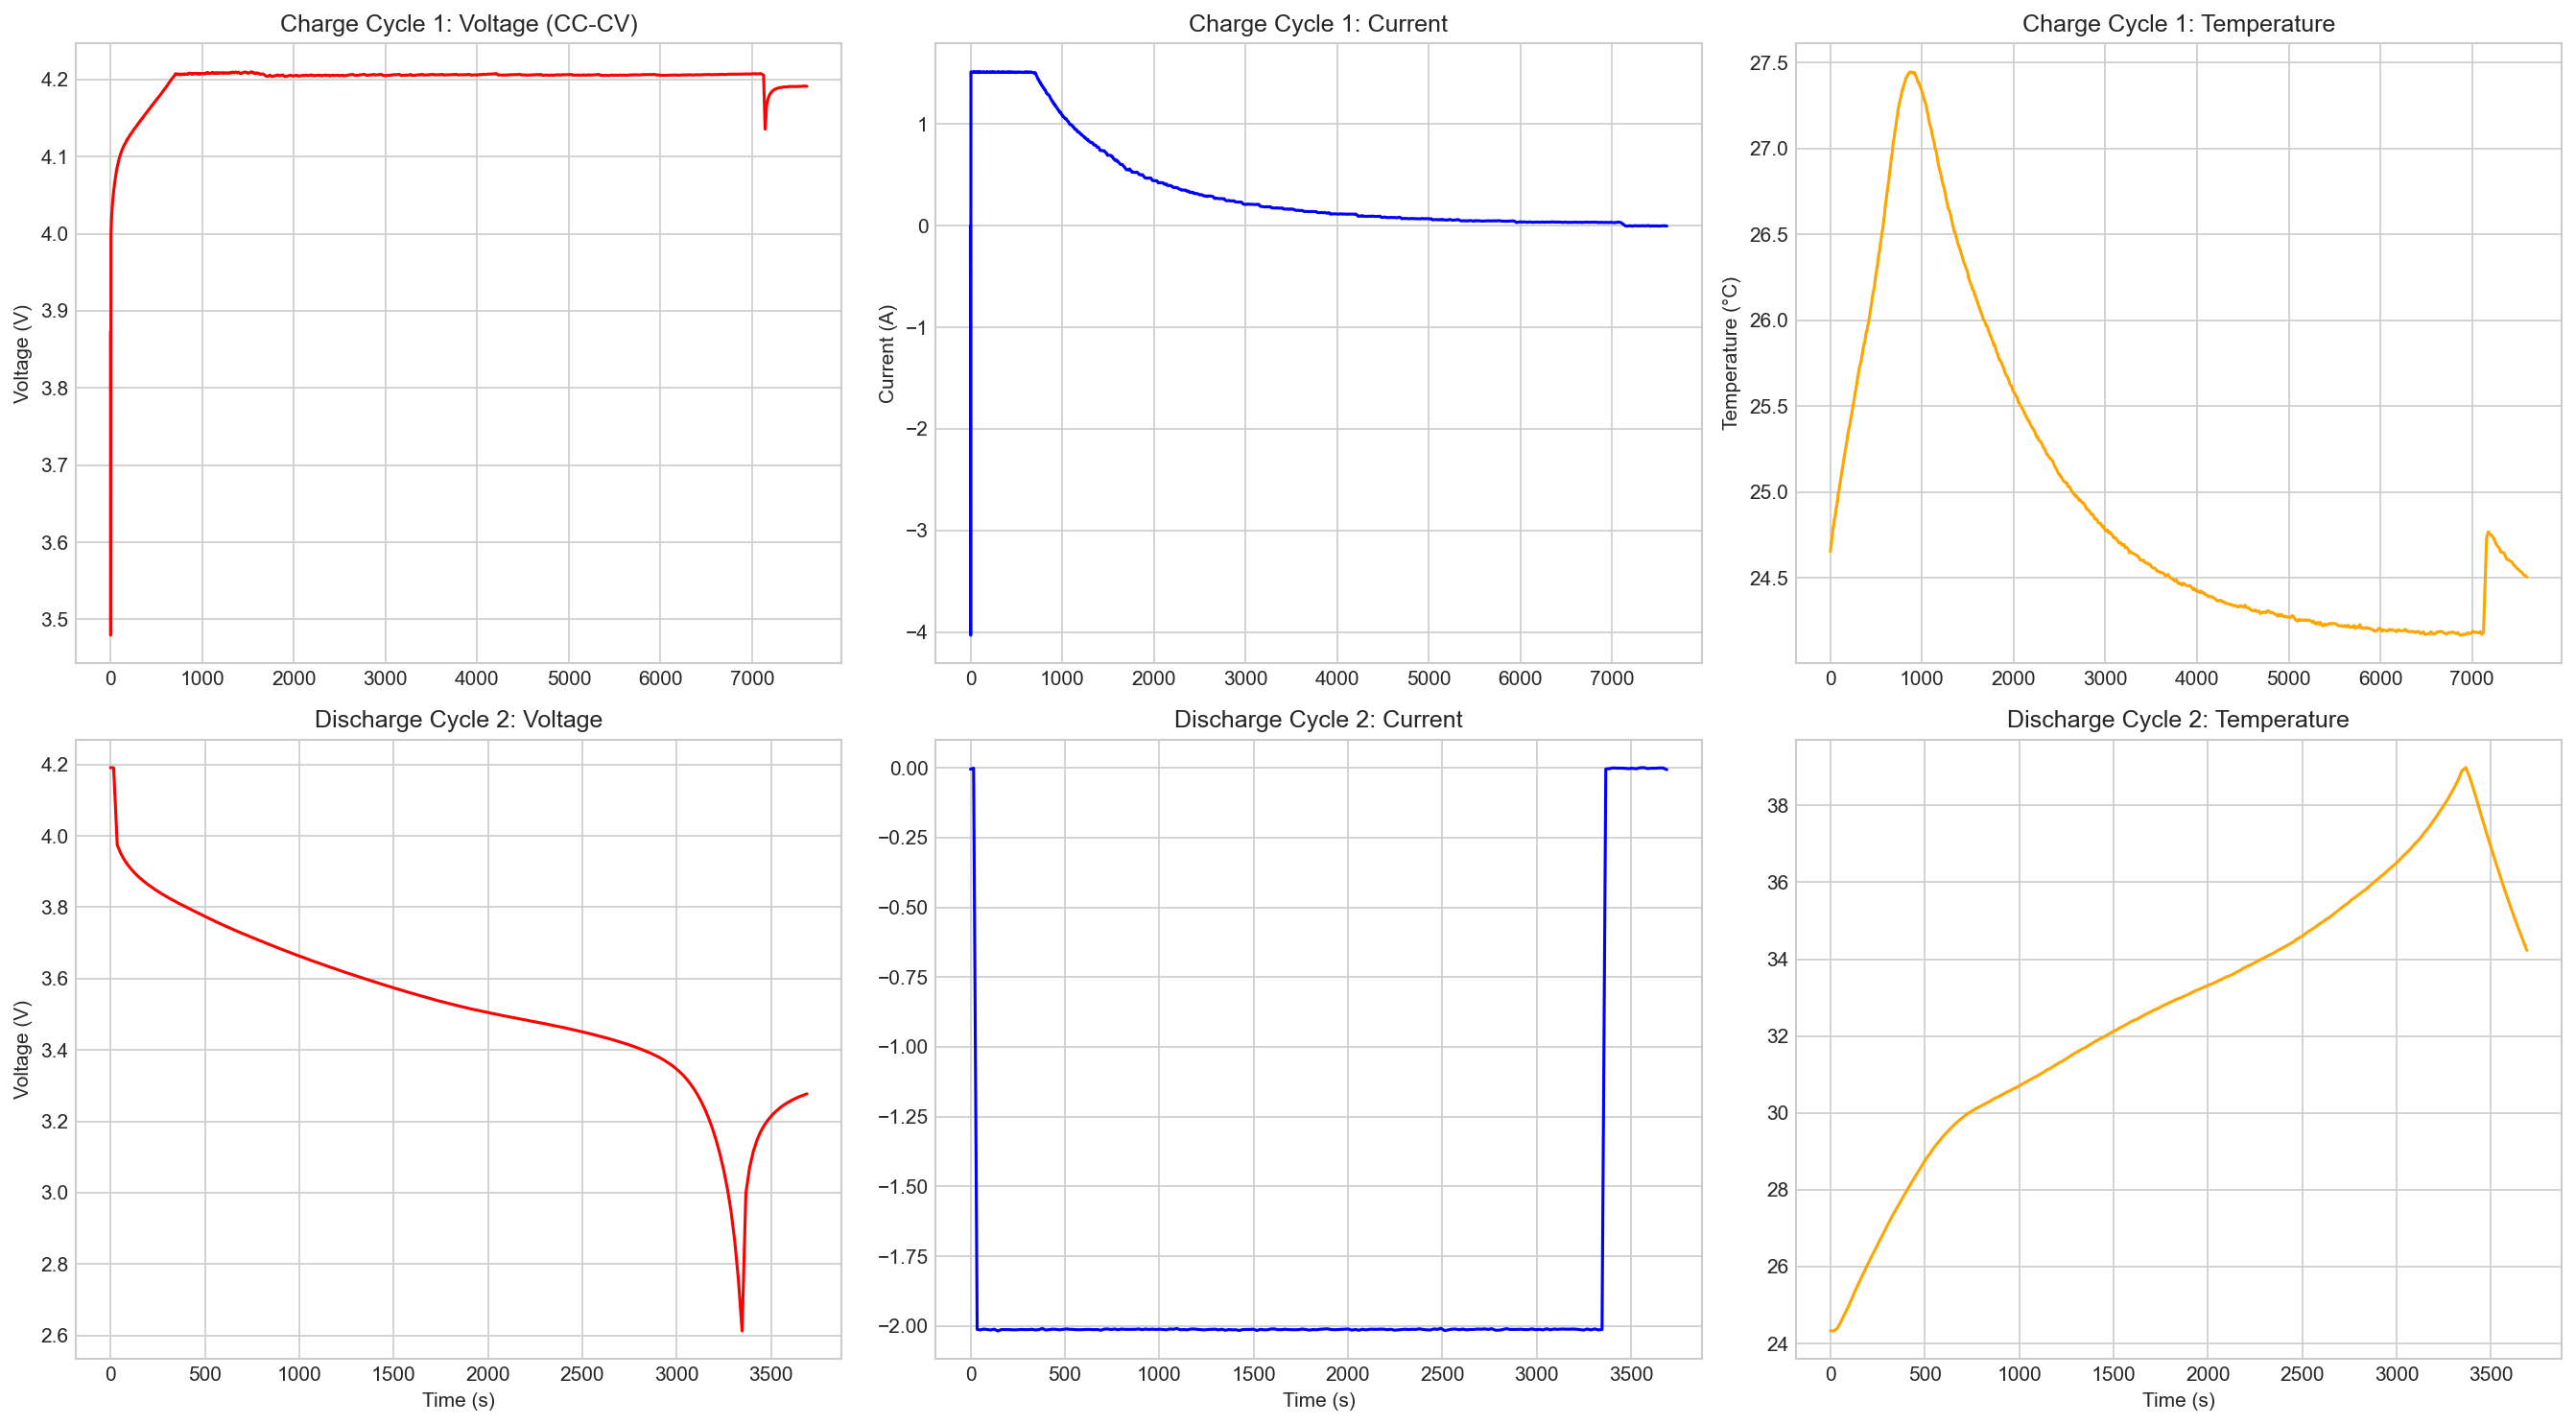

In [16]:
def plot_cycle(charge, discharge, charge_cycle, discharge_cycle):
    ch = charge[charge['cycle_idx'] == charge_cycle]
    dch = discharge[discharge['cycle_idx'] == discharge_cycle]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # === 충전 (Charge) 그래프 ===
    # 전압 (Voltage)
    axes[0, 0].plot(ch['Time'], ch['Voltage_measured'], color='red')
    axes[0, 0].set_title(f'Charge Cycle {charge_cycle}: Voltage (CC-CV)')
    axes[0, 0].set_ylabel('Voltage (V)')
    
    # 전류 (Current)
    axes[0, 1].plot(ch['Time'], ch['Current_measured'], color='blue')
    axes[0, 1].set_title(f'Charge Cycle {charge_cycle}: Current')
    axes[0, 1].set_ylabel('Current (A)')
    
    # 온도 (Temperature)
    axes[0, 2].plot(ch['Time'], ch['Temperature_measured'], color='orange')
    axes[0, 2].set_title(f'Charge Cycle {charge_cycle}: Temperature')
    axes[0, 2].set_ylabel('Temperature (°C)')

    # === 방전 (Discharge) 그래프 ===
    # 전압 (Voltage)
    axes[1, 0].plot(dch['Time'], dch['Voltage_measured'], color='red')
    axes[1, 0].set_title(f'Discharge Cycle {discharge_cycle}: Voltage')
    axes[1, 0].set_ylabel('Voltage (V)')
    axes[1, 0].set_xlabel('Time (s)')

    # 전류 (Current)
    axes[1, 1].plot(dch['Time'], dch['Current_measured'], color='blue')
    axes[1, 1].set_title(f'Discharge Cycle {discharge_cycle}: Current')
    axes[1, 1].set_xlabel('Time (s)')

    # 6. 온도 (Temperature)
    axes[1, 2].plot(dch['Time'], dch['Temperature_measured'], color='orange')
    axes[1, 2].set_title(f'Discharge Cycle {discharge_cycle}: Temperature')
    axes[1, 2].set_xlabel('Time (s)')

    plt.tight_layout()
    plt.show

# 함수 실행 (충전 1, 방전 2)
plot_cycle(charge, discharge, 1, 2)

(1) Charge

- 전압 그래프(빨강) : 쭉 오르다가 4.2V쯤에서 멈추고 옆으로 쭉

- 전류 그래프(파랑) : 잠깐 일정하다가 뚝 떨어짐

    -> CC-CV 충전방식

=> 배터리가 열화되면(노화되면) 4.2V에 도달하는 시간이 점점 빨라짐(capacity가 작아져서 금방 차게 되기 때문)

(2) Discharge

- 전압 그래프 : 4.2V에서 시작해서 서서히 떨어지다가 막판에 급격히 떨어짐

- 온도 그래프 : 방전되는 내내 올라감. (배터리가 노화되면 impedance가 커져서 온도가 더 많이 올라감)

### Impedance

In [17]:
imp

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance,Re,Rct,cycle_idx,type,ambient_temperature,start_time_raw
0,(-1+1j),(-1+1j),(1+0j),(-0.43892624830326377-0.107298295835479j),(0.07006937798290404-0.00047998469078178944j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
1,(820.6094970703125-36.23455047607422j),(337.0914611816406-82.9207763671875j),(2.3204145178633437+0.4633045948164565j),(0.13008840651776496-0.19711481029612374j),(0.06817886114940203-0.001190040925296937j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
2,(827.2421875-48.23122787475586j),(330.6315612792969-70.01371765136719j),(2.424192647592199+0.36746495469515333j),(0.058770560504133235+0.03330656583655633j),(0.06793257733714593-5.6826811936507056e-05j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
3,(827.1934814453125-56.195716857910156j),(330.8086242675781-61.73442459106445j),(2.4470021712116985+0.28677775364826635j),(0.0058135116366746726-0.060546548141956195j),(0.06691839226387165-0.0008787264015490232j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
4,(824.9295043945312-53.241477966308594j),(332.68267822265625-57.62901306152344j),(2.434304977711638+0.2616460702282485j),(0.12608106668700975-0.09044390544679616j),(0.06807105294348659-0.0001974802021297548j),0.044669,0.069456,41,impedance,24.0,[2008. 4. 18. 20. 55. ...
...,...,...,...,...,...,...,...,...,...,...,...
13339,(915.489013671875-64.04512023925781j),(230.14950561523438+91.9098892211914j),(3.334834919457856-1.6100379067382284j),(0.2450237439418051-0.04983619374573483j),(0.05030061471269835+0.0004471176940299067j),0.050036,0.074792,615,impedance,24.0,[2008. 5. 27. 21. 34. 28.64]
13340,(916.7255249023438+2.986217498779297j),(212.18885803222656+107.74581146240234j),(3.4403927232922893-1.732898190940107j),(0.26459423551817796-0.055235088103719486j),(0.05030061471269835+0.0004471176940299067j),0.050036,0.074792,615,impedance,24.0,[2008. 5. 27. 21. 34. 28.64]
13341,(914.61962890625+126.11148071289062j),(176.59803771972656+131.6827850341797j),(3.6706560245778346-2.0229597798418966j),(0.28857059933181783-0.058837097064953735j),(0.05030061471269835+0.0004471176940299067j),0.050036,0.074792,615,impedance,24.0,[2008. 5. 27. 21. 34. 28.64]
13342,(880.3408203125+293.8252868652344j),(136.84762573242188+146.8810272216797j),(4.060163697383427-2.2107488242884408j),(0.3176999700278338-0.05912720702491042j),(0.05030061471269835+0.0004471176940299067j),0.050036,0.074792,615,impedance,24.0,[2008. 5. 27. 21. 34. 28.64]


In [18]:
print("\n[Impedance 데이터]")
imp.info()

print("\n결측치 개수:")
print(imp.isna().sum())


[Impedance 데이터]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13344 entries, 0 to 13343
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Sense_current        13344 non-null  object 
 1   Battery_current      13344 non-null  object 
 2   Current_ratio        13344 non-null  object 
 3   Battery_impedance    13344 non-null  object 
 4   Rectified_Impedance  13344 non-null  object 
 5   Re                   13344 non-null  float64
 6   Rct                  13344 non-null  float64
 7   cycle_idx            13344 non-null  int64  
 8   type                 13344 non-null  object 
 9   ambient_temperature  13344 non-null  float64
 10  start_time_raw       13344 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 1.1+ MB

결측치 개수:
Sense_current          0
Battery_current        0
Current_ratio          0
Battery_impedance      0
Rectified_Impedance    0
Re                     0
Rct

In [19]:
# imp_cycle 단위로 요약

imp_cycle_stats = (
    imp
    .groupby("cycle_idx")
    .agg(
        Re_mean=("Re","mean"),
        Re_min=("Re","min"),
        Re_max=("Re","max"),
        Rct_mean=("Rct","mean"),
        Rct_min=("Rct","min"),
        Rct_max=("Rct","max"),
        imp_samples=("Re","size")
    )
    .reset_index()
)

imp_cycle_stats

,cycle_idx,Re_mean,Re_min,Re_max,Rct_mean,Rct_min,Rct_max,imp_samples
0,41,0.044669,0.044669,0.044669,0.069456,0.069456,0.069456,48
1,43,0.046687,0.046687,0.046687,0.076275,0.076275,0.076275,48
2,45,0.044843,0.044843,0.044843,0.067972,0.067972,0.067972,48
3,47,0.046195,0.046195,0.046195,0.074534,0.074534,0.074534,48
4,49,0.045101,0.045101,0.045101,0.068528,0.068528,0.068528,48
...,...,...,...,...,...,...,...,...
273,605,0.058801,0.058801,0.058801,0.082370,0.082370,0.082370,48
274,607,0.057630,0.057630,0.057630,0.087424,0.087424,0.087424,48
275,609,0.058984,0.058984,0.058984,0.082522,0.082522,0.082522,48
276,611,0.057824,0.057824,0.057824,0.089757,0.089757,0.089757,48


Cycle이 증가할수록 Re와 Rct 값이 전반적으로 증가하는 패턴

-> 시간이 지날수록 배터리 내부저항과 전하 전달 저항이 모두 증가

In [20]:
print("\n[임피던스 사이클 요약 describe]")
imp_cycle_stats.describe()


[임피던스 사이클 요약 describe]


,cycle_idx,Re_mean,Re_min,Re_max,Rct_mean,Rct_min,Rct_max,imp_samples
count,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.000000,278.0
mean,327.859712,0.054245,0.054245,0.054245,0.077340,0.077340,0.077340,48.0
std,166.212638,0.005490,0.005490,0.005490,0.006367,0.006367,0.006367,0.0
min,41.000000,0.043559,0.043559,0.043559,0.064883,0.064883,0.064883,48.0
25%,185.500000,0.049161,0.049161,0.049161,0.071511,0.071511,0.071511,48.0
50%,328.000000,0.055850,0.055850,0.055850,0.077487,0.077487,0.077487,48.0
75%,469.500000,0.058815,0.058815,0.058815,0.082563,0.082563,0.082563,48.0
max,615.000000,0.063516,0.063516,0.063516,0.089757,0.089757,0.089757,48.0


- 데이터가 특정 구간에 치우치지 않고 비교적 균형 있게 cycle 전 범위를 커버

    -> Q1(25%) = ~185 cycles / Q3(75%) = ~469 cycles

- Noise가 적고 안정적인 측정값

    - std(표준편차)가 두 임피던스 값 모두 크지 않음

- Re_mean과 Rct_mean 모두 cycle이 증가할수록 값이 상승하는 패턴을 보이기 때문에, 이 데이터는 배터리 열화 progression을 명확히 반영

- Rct_mean의 분포 폭이 Re_mean보다 조금 더 큼 → 전극 반응 degradation이 더 민감하게 변화